## Intel images - model deployment

This notebook outlines steps to deploy a CNN model as a prediction web service.

It follows on from *Intel images - model building.ipynb*, taking the model developed in that notebook and packages it using Docker and the Tensorflow extended framework for model deployment. 

Note: instructions are written assuming a windows device and using Minikube

### Setup and config

**Import libraries**

In [18]:
import os
import shutil
import pathlib
import json

import requests
import numpy as np
import matplotlib.pyplot as plt

from app.image_functions import get_img, convert_from_bytes

In [6]:
# define local path where the models are located and get it in terms of forward slashes
model_folder = os.path.join(os.getcwd(),"models")
os.makedirs(model_folder, exist_ok=True)

model_path = pathlib.PureWindowsPath(model_folder).as_posix()
node_tmp_path = "/var/tmp"

**Start minikube**

Start a minikube cluster and mount the local folder containing your ML models to the Kubernetes node. 

In [5]:
! minikube start --mount=True --mount-string="{model_path}:{node_tmp_path}" --vm-driver=docker

* minikube v1.24.0 on Microsoft Windows 10 Home 10.0.19044 Build 19044
* Using the docker driver based on user configuration
* Starting control plane node minikube in cluster minikube
* Pulling base image ...
* Creating docker container (CPUs=2, Memory=2200MB) ...
* Preparing Kubernetes v1.22.3 on Docker 20.10.8 ...
  - Generating certificates and keys ...
  - Booting up control plane ...
  - Configuring RBAC rules ...
* Verifying Kubernetes components...
  - Using image gcr.io/k8s-minikube/storage-provisioner:v5
* Enabled addons: storage-provisioner, default-storageclass
* Done! kubectl is now configured to use "minikube" cluster and "default" namespace by default


### Deploy the model to Kubernetes

**Copy chosen model to the mounted folder**

Once you've decided which model to use, copy it in to the *./deployment/models* directory which is accessible from the kubernetes node. 

It must be in the format required by tensorflow, with the path *model-name/version-number/saved-model.pb*.  

In [17]:
# choose the model for deployment 
exp_model_folder = os.path.abspath(os.path.join(os.getcwd(),'..','experimentation','models'))
model = input("Input model-name: ")
version = input("Input model-version: ")

Input model-name: LeNet5
Input model-version: 1


In [27]:
# copy that model across to the deployment folder
exp_model_path = os.path.join(exp_model_folder, model)
dep_model_path = os.path.join(model_folder, model, version)
os.makedirs(dep_model_path, exist_ok=True)

shutil.copytree(exp_model_path, dep_model_path, dirs_exist_ok=True)

'C:\\Users\\eddlo\\Python\\Projects\\TF-images\\TF-IntelImages\\deployment\\models\\LeNet5\\1'

**Deploy the model using Helm**

Use the Helm CLI to deploy the model to the kubernetes cluster, passing the model name as an argument. The helm chart is stored in the repo under *./helm-cnn* and uses the *tensorflow/serving* docker image to run the model as a prediction web service.  

In [29]:
# deploy the model using helm chart
! helm upgrade --install tf-images helm-cnn --set models.modelName={model}

Release "tf-images" does not exist. Installing it now.
NAME: tf-images
LAST DEPLOYED: Tue Mar 15 15:17:45 2022
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None


Next, forward the service on minikube to a port on localhost. Run this at a terminal (e.g. Windows DOS or Powershell).


``` minikube service tfserving-service -n model-serving ```

Minikube will provide the port number, enter it below.

In [33]:
host = "127.0.0.1"
tunnel_port = input("Port provided by Minikube: ")

Port provided by Minikube: 60476


### Testing the API

**Find a suitable image for testing**

To test the prediction service, we first need an example image. I have used a site called Pexels which allows free access to many images through their API (you must first sign-up to get an API key). Run a query to their API with a chosen category (e.g. forest) and convert the response into a numpy array that can be passed to our prediction service.  

In [34]:
# retrieve API key
with open('app/pexels_api.txt','r') as f:
    api_key = f.read()

In [61]:
# retrieve a random image from the pexels API and convert to a numpy array
category = input("Choose the category: ")
img_bytes = get_img(category, api_key, base_url="http://api.pexels.com/v1/")
arr = convert_from_bytes(img_bytes, size=(150,150))

Choose the category: forest


**Test the prediction service**

Now, send a POST request to the prediction web service to check whether it will correctly classify the image.

Display the image that was sent and review the predictions that the model made.

In [62]:
# define the inputs for the POST request
url = f"http://{host}:{tunnel_port}/v1/models/lenet5:predict"
headers = {'Content-Type': 'application/json'}
data = json.dumps({"instances":[arr.tolist()]})

# pass a request to the model service
r = requests.post(url=url, headers=headers, data=data)
if r.status_code == 200: predict_probas = r.json()['predictions']

Actual: forest, Predicted: forest

Prediction probabilities:
 - buildings: 5.35%
 - forest: 85.55%
 - glacier: 4.82%
 - mountain: 0.28%
 - sea: 1.61%
 - street: 2.40%


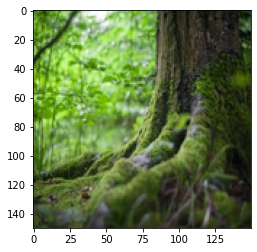

In [63]:
# map probabilties to class labels
classes = ["buildings","forest","glacier","mountain","sea","street"]
y_pred_class_idx = [np.array(p).argmax(axis=-1) for p in predict_probas]

# display the image and return the prediction result and class probabilities
plt.imshow(arr)
print(f"Actual: {category}, Predicted: {classes[y_pred_class_idx[0]]}")
print()
print("Prediction probabilities:")
for p in list(zip(classes, predict_probas[0])):
    print(f" - {p[0]}: {p[1]*100:.2f}%")

**Tear down**

Tear down the service once you have finished testing.

In [64]:
! helm uninstall tf-images

release "tf-images" uninstalled


In [65]:
! minikube delete

* Deleting "minikube" in docker ...
* Deleting container "minikube" ...
* Removing C:\Users\eddlo\.minikube\machines\minikube ...
* Removed all traces of the "minikube" cluster.
